# MLP实现方式

* 1958 年，心理学家Rosenblatt 提出 Perceptron（感知机）模型
* 1984 年，Hinton等人提出的Bolzmann机
* 1986 年，Rumelhart、Hinton、Williams 提出反向传播(BP)算法，随之，MLP（Multi-Layer Perceptron，多层感知机，有隐层）变得可行，并流行
* **MLP 可以看做最原始的神经网络**，并在此基础上逐渐发展出各种 NN 和 DeepNN 网络模型



# Data

In [1]:
import os
import numpy as np
from mxnet import ndarray as nd, autograd as ag, gluon
from dataloader import DataLoader

In [2]:
dl = DataLoader(os.environ["HOME"] + '/.datasets/Han.Xiao/fashion-mnist/')
train_img,train_labels = dl.get_data(kind='train')
test_img,test_labels = dl.get_data(kind='t10k')

train_img_nd = nd.array(train_img).astype(np.float32)/255
train_lab_nd = nd.array(train_labels).astype(np.float32)
test_img_nd = nd.array(test_img).astype(np.float32)/255
test_lab_nd = nd.array(test_labels).astype(np.float32)

def data_iter(batch_size=100, kind='train'):
    if kind != 'train':
        idx = list(range(len(test_labels)))
        for i in range(0,len(test_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(test_labels))])
            yield nd.take(test_img_nd,j), nd.take(test_lab_nd,j)
    else:
        idx = list(range(len(train_labels)))
        for i in range(0,len(train_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(train_labels))])
            yield nd.take(train_img_nd,j), nd.take(train_lab_nd,j)

# Model

In [3]:
num_inputs = 28*28
num_outputs = 10

num_hidden = 256
weight_scale = .01

# MXNet 的公式是 y=XW+b，吴恩达的公式是 y=WX+b，所以两者W的shape定义是相反的。
W1 = nd.random_normal(shape=(num_inputs,num_hidden), scale=weight_scale)
b1 = nd.zeros(num_hidden)

W2 = nd.random_normal(shape=(num_hidden,num_outputs),scale=weight_scale)
b2 = nd.zeros(num_outputs)

params = [W1,b1,W2,b2]
for p in params:
    p.attach_grad()

In [4]:
def relu(X):
    return nd.maximum(X,0)

In [5]:
def net(X):
    X = X.reshape((-1, num_inputs))
    h1 = relu(nd.dot(X,W1) + b1)
    output = nd.dot(h1,W2) + b2
    return output

In [6]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

# Train

In [7]:
def SGD(params, lr):
    for p in params:
        p[:] = p - lr*p.grad

In [8]:
def accuracy(yhat,y):
    return nd.mean(yhat.argmax(axis=1)==y).asscalar()

In [9]:
learning_rate = .5
batch_size = 100
epochs = 100

import datetime
t1 = datetime.datetime.now()

for epoch in range(epochs):
    train_loss = 0.
    train_accu = 0.
    
    for data, label in data_iter(batch_size=batch_size):
        with ag.record():
            yhat = net(data)
            loss = softmax_cross_entropy(yhat,label)
        loss.backward()
        
        SGD(params, learning_rate/batch_size)
                
        train_loss += nd.mean(loss).asscalar()
        train_accu += accuracy(yhat,label)

    print("epoch:%d; loss:%f; accu:%f" % (epoch, 
                    train_loss/len(train_labels)*batch_size,
                    train_accu/len(train_labels)*batch_size))
    
print(datetime.datetime.now()-t1)

epoch:0; loss:0.669319; accu:0.750100
epoch:1; loss:0.437184; accu:0.836450
epoch:2; loss:0.387346; accu:0.856450
epoch:3; loss:0.357315; accu:0.867900
epoch:4; loss:0.336028; accu:0.876300
epoch:5; loss:0.318625; accu:0.883250
epoch:6; loss:0.305061; accu:0.887550
epoch:7; loss:0.293197; accu:0.891217
epoch:8; loss:0.282563; accu:0.895033
epoch:9; loss:0.272034; accu:0.900050
epoch:10; loss:0.263254; accu:0.903200
epoch:11; loss:0.254814; accu:0.906333
epoch:12; loss:0.246816; accu:0.909667
epoch:13; loss:0.239701; accu:0.911767
epoch:14; loss:0.233559; accu:0.914600
epoch:15; loss:0.227037; accu:0.917233
epoch:16; loss:0.220851; accu:0.918633
epoch:17; loss:0.213097; accu:0.921767
epoch:18; loss:0.209658; accu:0.923267
epoch:19; loss:0.201626; accu:0.926933
epoch:20; loss:0.196941; accu:0.928217
epoch:21; loss:0.193499; accu:0.929433
epoch:22; loss:0.188997; accu:0.931000
epoch:23; loss:0.182449; accu:0.933917
epoch:24; loss:0.178399; accu:0.934817
epoch:25; loss:0.174884; accu:0.936

# Test

In [10]:
yhat = net(train_img_nd).argmax(axis=1).asnumpy()
yhat

array([2., 9., 6., ..., 8., 8., 7.], dtype=float32)

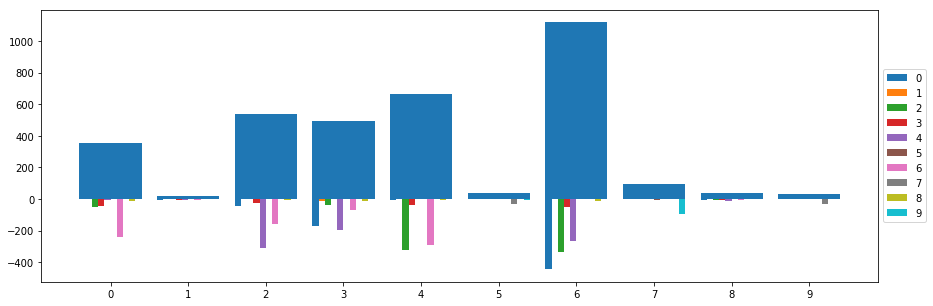

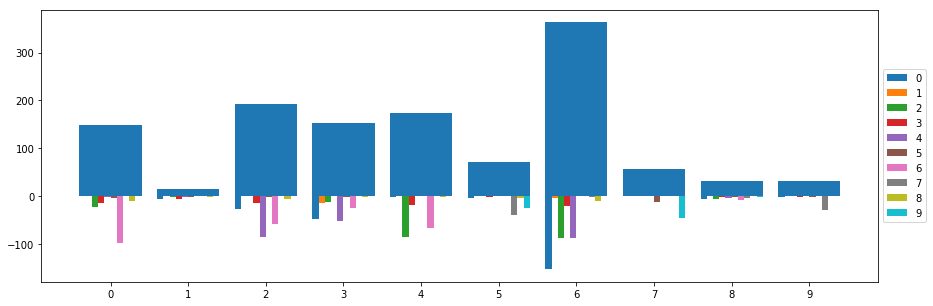

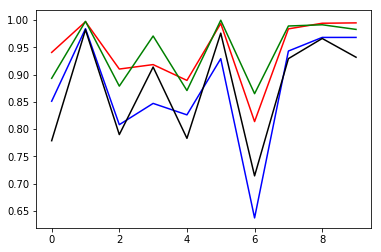

In [11]:
from matplotlib import pyplot as plt
from statiser import Statistics
train_statistics = Statistics(net(train_img_nd).argmax(axis=1).asnumpy(), 
                              train_lab_nd.asnumpy())
test_statistics = Statistics(net(test_img_nd).argmax(axis=1).asnumpy(), 
                             test_lab_nd.asnumpy())
train_statistics.show()
test_statistics.show()
plt.plot(range(10),train_statistics.Recall(),'r')
plt.plot(range(10),train_statistics.Precision(),'g')
plt.plot(range(10),test_statistics.Recall(),'b')
plt.plot(range(10),test_statistics.Precision(),'k')
plt.show()